# Basic SLS problem

This notebook deals with a basic, state-feedback and noiseless, SLS-problem using the curvilinear HCW coordinates. 

In [1]:
import sys, time
sys.path.insert(0,'C:\\Users\\fabia\\Documents\\Master\\Thesis\\Examples\\SLSpy')

from slspy import *

(CVXPY) Feb 23 08:20:29 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: Kan opgegeven module niet vinden.')


In [2]:
def state_fdbk_example():
    sys = LTI_System (
        Nx = 10, Nw = 10
    )

    # generate sys._A, sys._B2
    generate_doubly_stochastic_chain (
        system_model = sys,
        rho = 1,
        actuator_density = 1,
        alpha = 0.2
    )
    generate_BCD_and_zero_initialization(sys)

    sim_horizon = 25
    # generate noise
    noise = FixedNoiseVector (Nw = sys._Nw, horizon = sim_horizon)
    noise.generateNoiseFromNoiseModel (cls = ZeroNoise)
    noise._w[0][sys._Nw//2] = 10

    simulator = Simulator (
        system = sys,
        noise = noise,
        horizon = sim_horizon
    )

    ## (1) basic sls (centralized controller)
    # use SLS controller synthesis algorithm
    synthesizer = SLS (
        system_model = sys,
        FIR_horizon = 20
    )
    # set SLS objective
    synthesizer << SLS_Obj_H2()

    # # synthesize controller (the generated controller is actually initialized)
    # # and use the synthesized controller in simulation
    # simulator.setController (
    #     controller = synthesizer.synthesizeControllerModel ()
    # )

    # # run the simulation
    # x_history, y_history, z_history, u_history, w_history = simulator.run ()

    # Bu_history = matrix_list_multiplication(sys._B2,u_history)
    # plot_heat_map(x_history, Bu_history, 'Centralized')


    ## (2) d-localized sls
    dlocalized = SLS_Cons_dLocalized (
        act_delay = 1,
        comm_speed = 2,
        d = 3
    )
    synthesizer << dlocalized

    tic = time.perf_counter()

    for i in range(1):
        simulator.setController (
            controller = synthesizer.synthesizeControllerModel ()
        )
    toc = time.perf_counter()
    print(f"It took {toc - tic:0.4f} seconds!")

    x_history, y_history, z_history, u_history, w_history = simulator.run ()

    Bu_history = matrix_list_multiplication(sys._B2,u_history)
    plot_heat_map(x_history, Bu_history, 'Localized')


    ## (3) approximate d-localized sls
    # approx_dlocalized = SLS_Cons_ApproxdLocalized (
    #     base = dlocalized,
    #     rob_coeff = 10e3
    # )
    # approx_dlocalized._comm_speed = 1

    # # set the constriant
    # synthesizer << approx_dlocalized

    # controller = synthesizer.synthesizeControllerModel ()
    # simulator.setController (controller=controller)

    # x_history, y_history, z_history, u_history, w_history = simulator.run ()

    # Bu_history = matrix_list_multiplication(sys._B2,u_history)
    # plot_heat_map(x_history, Bu_history, 'Approximately Localized')

It took 1.3537 seconds!


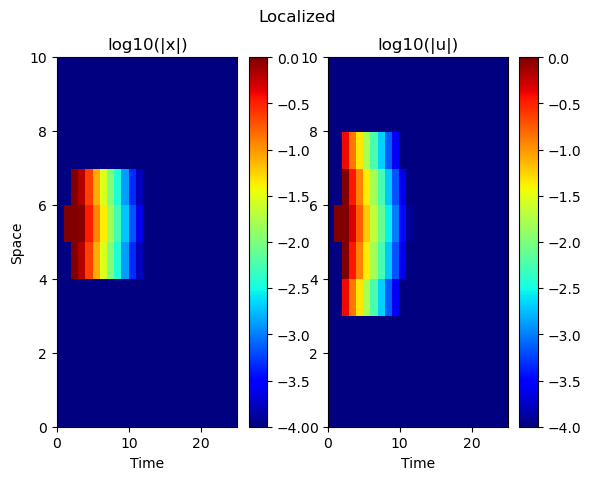

In [3]:
state_fdbk_example()
keep_showing_figures()